# The transient Universe

### Tasks

Let's go back to our previous example on the astrophysical transient.

8. Fit the same model from before with the same priors, but this time use nested sampling.

$$y=b,\text{ for } t<t_0$$ 
$$y=b+A\text{exp}[-\alpha(t-t_0)], \text{ for } t\geq t_0$$ 

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:

$$y=b+A\text{exp}[-(t-t_0)^2/2\sigma_W^2]$$ 

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import dynesty
import corner
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
np.random.seed(336)

data = np.load("../solutions/transient.npy")
# The first column is time (arbitrary units), the second column is flux (arbitrary units), 
# the third column are homoescedastic measurement uncertainties on the flux.

time = np.array(data[:, 0])
flux = np.array(data[:, 1])
flux_error = np.array(data[:, 2])

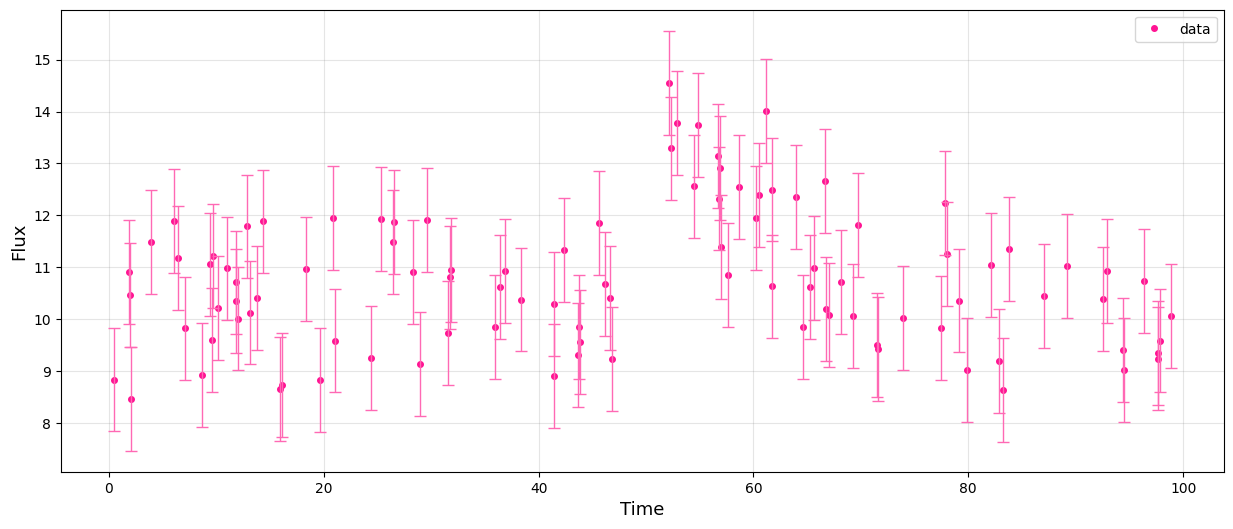

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(time, flux, lw = 0.5, ls = '', c = 'deeppink', marker = 'o', markersize = 4, label = 'data')
plt.errorbar(time, flux, yerr=flux_error, fmt = 'none', linewidth = 1, c = 'hotpink', capsize = 4)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Flux', fontsize = 13)
plt.legend(loc='best')
plt.grid(color='grey', alpha = 0.2)
plt.show()

First, I want to check that the parameters I find by using nested sampling are comparable with the ones I found with MCMC for the burst model.

### Burst model

#### MCMC parameters:
- $A=5.43_{-1.84}^{+3.40}$
- $b=10.30_{-0.20}^{+0.19}$
- $t_0=49.09_{-2.03}^{+2.72}$
- $\alpha=0.12_{-0.04}^{+0.05}$

In [29]:
def burst_model(theta, t):
    A, b, t0, alpha = theta
    return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
'''
def lnLikelihood(theta, t, f, err_f):
    f_model = burst_model(theta, t)
    return -0.5 * np.sum((f-f_model)**2/(err_f**2) + np.log(2*np.pi*err_f**2))     # Normalized for the evaluation of a single model
'''

def lnLikelihood(theta, t, f, err_f):
    f_model = burst_model(theta, t)
    return -0.5 * np.sum((f-f_model)**2/(err_f**2))


def prior_transform(u, model):
    A_min, A_max = 0, 50
    b_min, b_max = 0, 50
    t0_min, t0_max = 0, 100
    alpha_min, alpha_max = np.exp(-5), np.exp(5) 
    sigmaW_min,sigmaW_max=np.exp(-2),np.exp(2)

    A = scipy.stats.uniform(loc=A_min,scale=A_max-A_min).ppf(u[0])
    b = scipy.stats.uniform(loc=b_min,scale=b_max-b_min).ppf(u[1])
    t0 = scipy.stats.uniform(loc=t0_min,scale=t0_max-t0_min).ppf(u[2])

    if(model=='burst_model'):   
        alpha = scipy.stats.loguniform.ppf(u[3],alpha_min, alpha_max)
        return A, b, t0, alpha

    # I'm already defining the prior so that it'll work also for the gaussian model later.
    if(model=='gaussian_model'):
        sigmaW = scipy.stats.loguniform.ppf(u[3],sigmaW_min,sigmaW_max)
        return A, b, t0, sigmaW


In [30]:
ndim = 4
sampler = NestedSampler(lnLikelihood, prior_transform, ndim, logl_args=[time, flux, flux_error], ptform_args=['burst_model'])
sampler.run_nested()
results = sampler.results

C:\Users\lilit\AppData\Local\Temp\ipykernel_13684\2489511025.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
C:\Users\lilit\AppData\Local\Temp\ipykernel_13684\2489511025.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
1718it [00:55,  5.46it/s, bound: 1 | nc: 2 | ncall: 17201 | eff(%):  9.988 | loglstar:   -inf < -191.126 <    inf | logz: -199.210 +/-  0.120 | dlogz: 121.928 >  0.509]     C:\Users\lilit\AppData\Local\Temp\ipykernel_13684\2489511025.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
C:\Users\lilit\AppData\Local\Temp\ipykernel_13684\2489511025.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
1902it [00:58, 57.21it/s, bound: 1 | nc: 8 | ncall: 17939 | eff(%): 10.603 | loglstar:   -inf < -146.256 <    inf | logz: -154.706 +/-  0.122 | dlogz

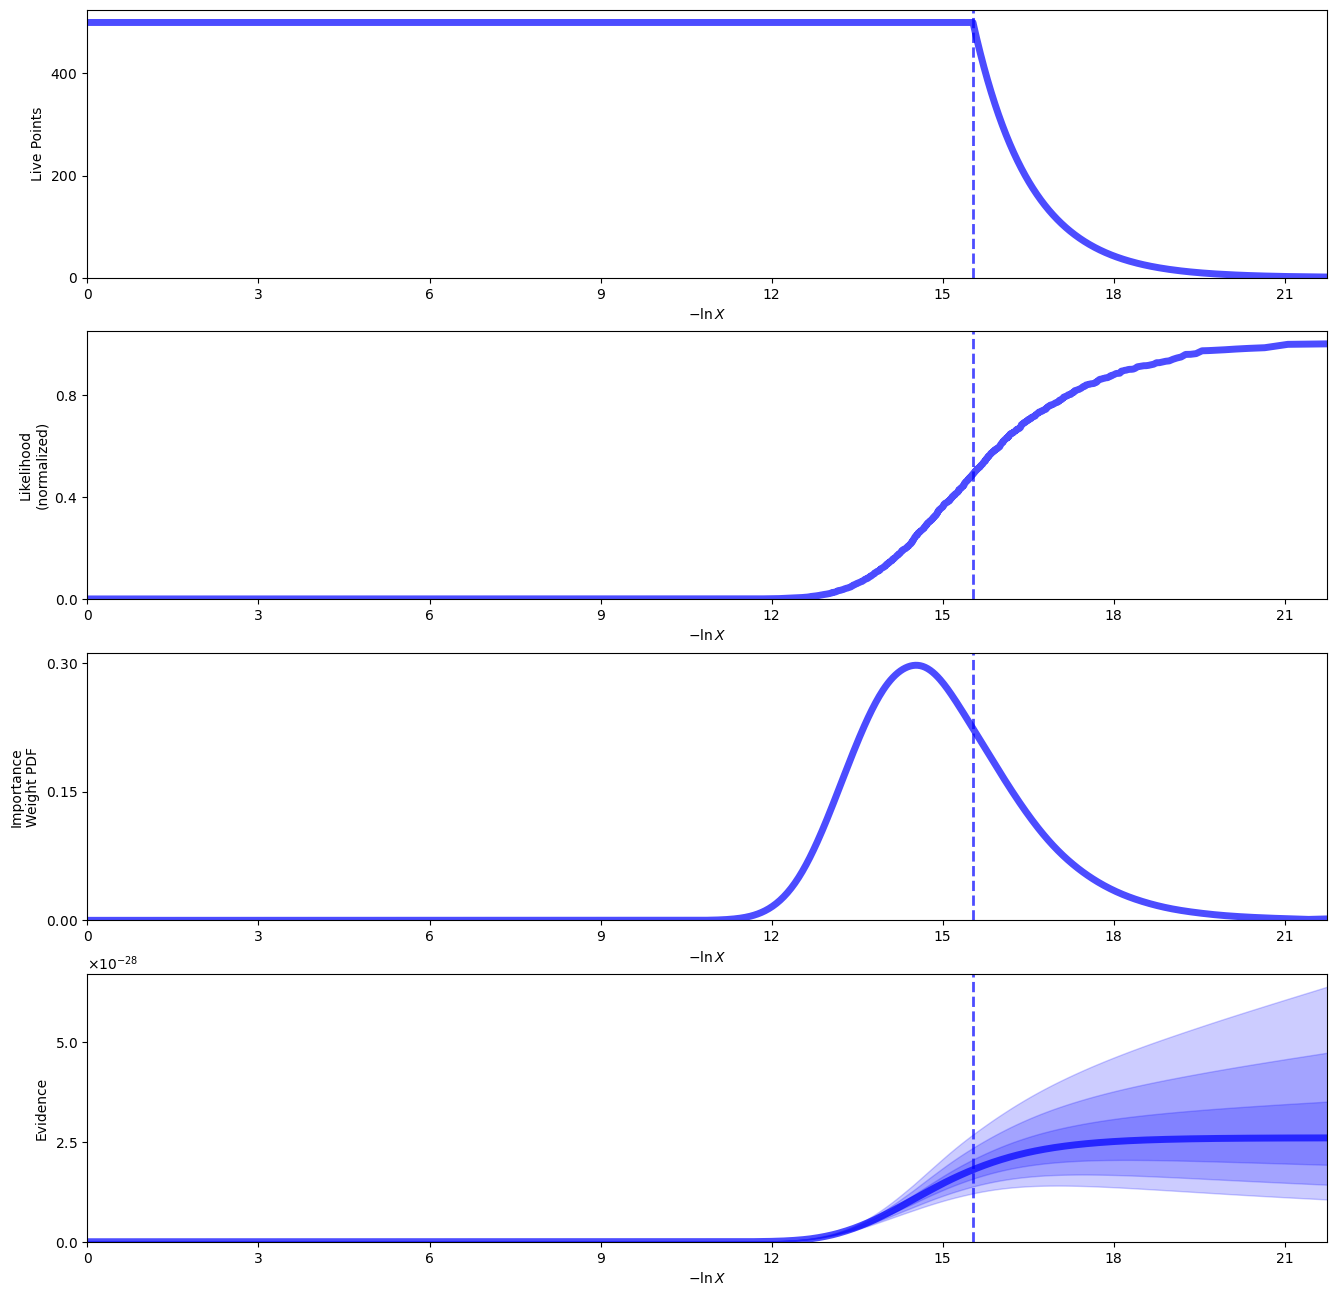

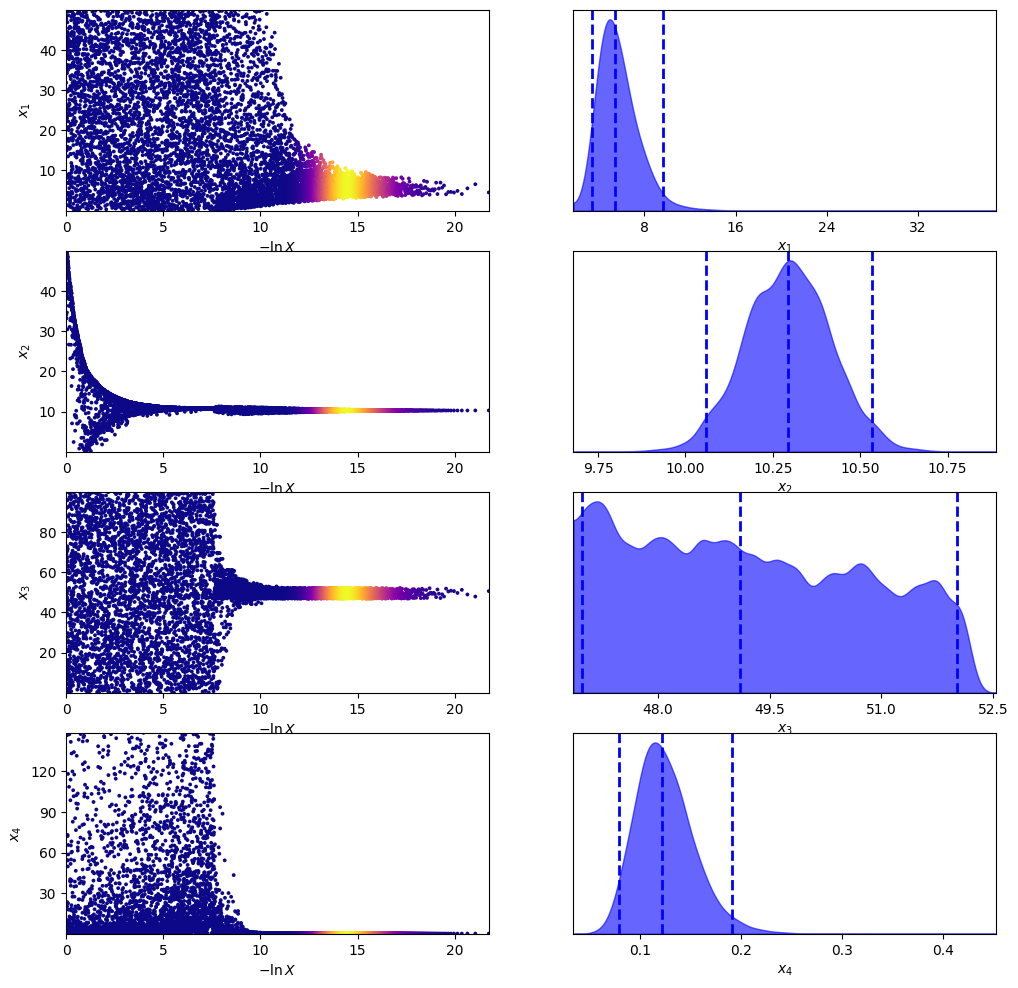

In [31]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)
tfig, taxes = dyplot.traceplot(results)
plt.show()

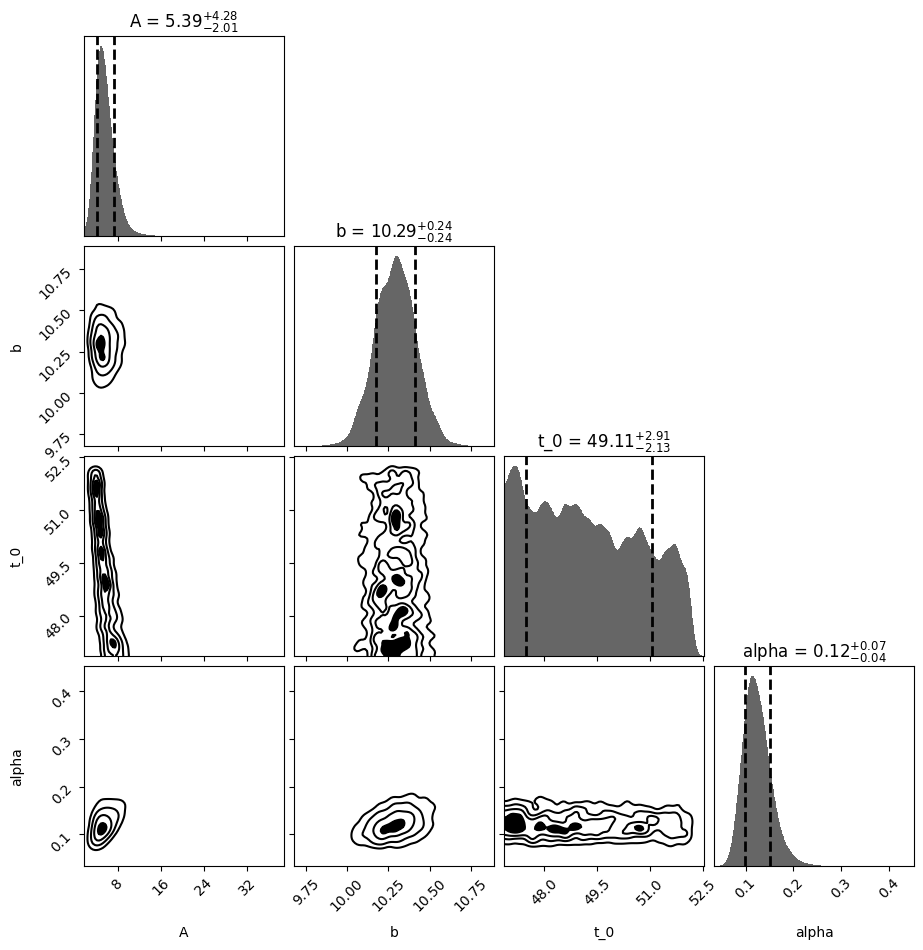

In [32]:
# Plot the cornerplots
labels = ["A", "b", "t_0", "alpha"]
fig, axes = dyplot.cornerplot(results, show_titles=True, quantiles=[0.16, 0.84], labels=labels)
plt.show()

### Summary of the results

#### MCMC parameters:
- $A=5.43_{-1.84}^{+3.40}$
- $b=10.30_{-0.20}^{+0.19}$
- $t_0=49.09_{-2.03}^{+2.72}$
- $\alpha=0.12_{-0.04}^{+0.05}$

#### Nested sampling parameters:
- $A=5.42_{-2.07}^{+4.02}$
- $b=10.30_{-0.25}^{+0.25}$
- $t_0=49.10_{-2.16}^{+2.90}$
- $\alpha=0.12_{-0.04}^{+0.07}$

The results obtained for the burst model through the MCMC are compatible with the ones obtained through nested sampling.

Now we can confront the burst model with the gaussian one.

### Gaussian model

In [22]:
def gaussian_model(theta, t):
    A, b, t0, sigmaW = theta     
    return b+A*np.exp(-(((t-t0)/sigmaW)**2 )/2)

def lnLikelihood(theta, t, f, err_f, model):
    if (model == 'burst_model'):
        f_model = burst_model(theta, t)
    elif (model == 'gaussian_model'):
        f_model = gaussian_model(theta, t)

    # I'm confronting two models so I don't need the evidences, only their ratio, so I don't need a normalized lnLikelihood.
    return -0.5 * np.sum((f-f_model)**2/(err_f**2))     

In [23]:
ndim = 4
sampler = NestedSampler(lnLikelihood, prior_transform, ndim, logl_args=[time, flux, flux_error, 'gaussian_model'], ptform_args=['gaussian_model'])
sampler.run_nested()
resultsG = sampler.results

3955it [03:29,  1.44it/s, bound: 55 | nc: 317 | ncall: 59042 | eff(%):  6.699 | loglstar:   -inf < -86.399 <    inf | logz: -94.128 +/-  0.114 | dlogz: 32.132 >  0.509]     C:\Users\lilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3970it [03:49,  1.10s/it, bound: 62 | nc: 108 | ncall: 64388 | eff(%):  6.166 | loglstar:   -inf < -86.280 <    inf | logz: -94.101 +/-  0.114 | dlogz: 32.076 >  0.509]C:\Users\lilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds de

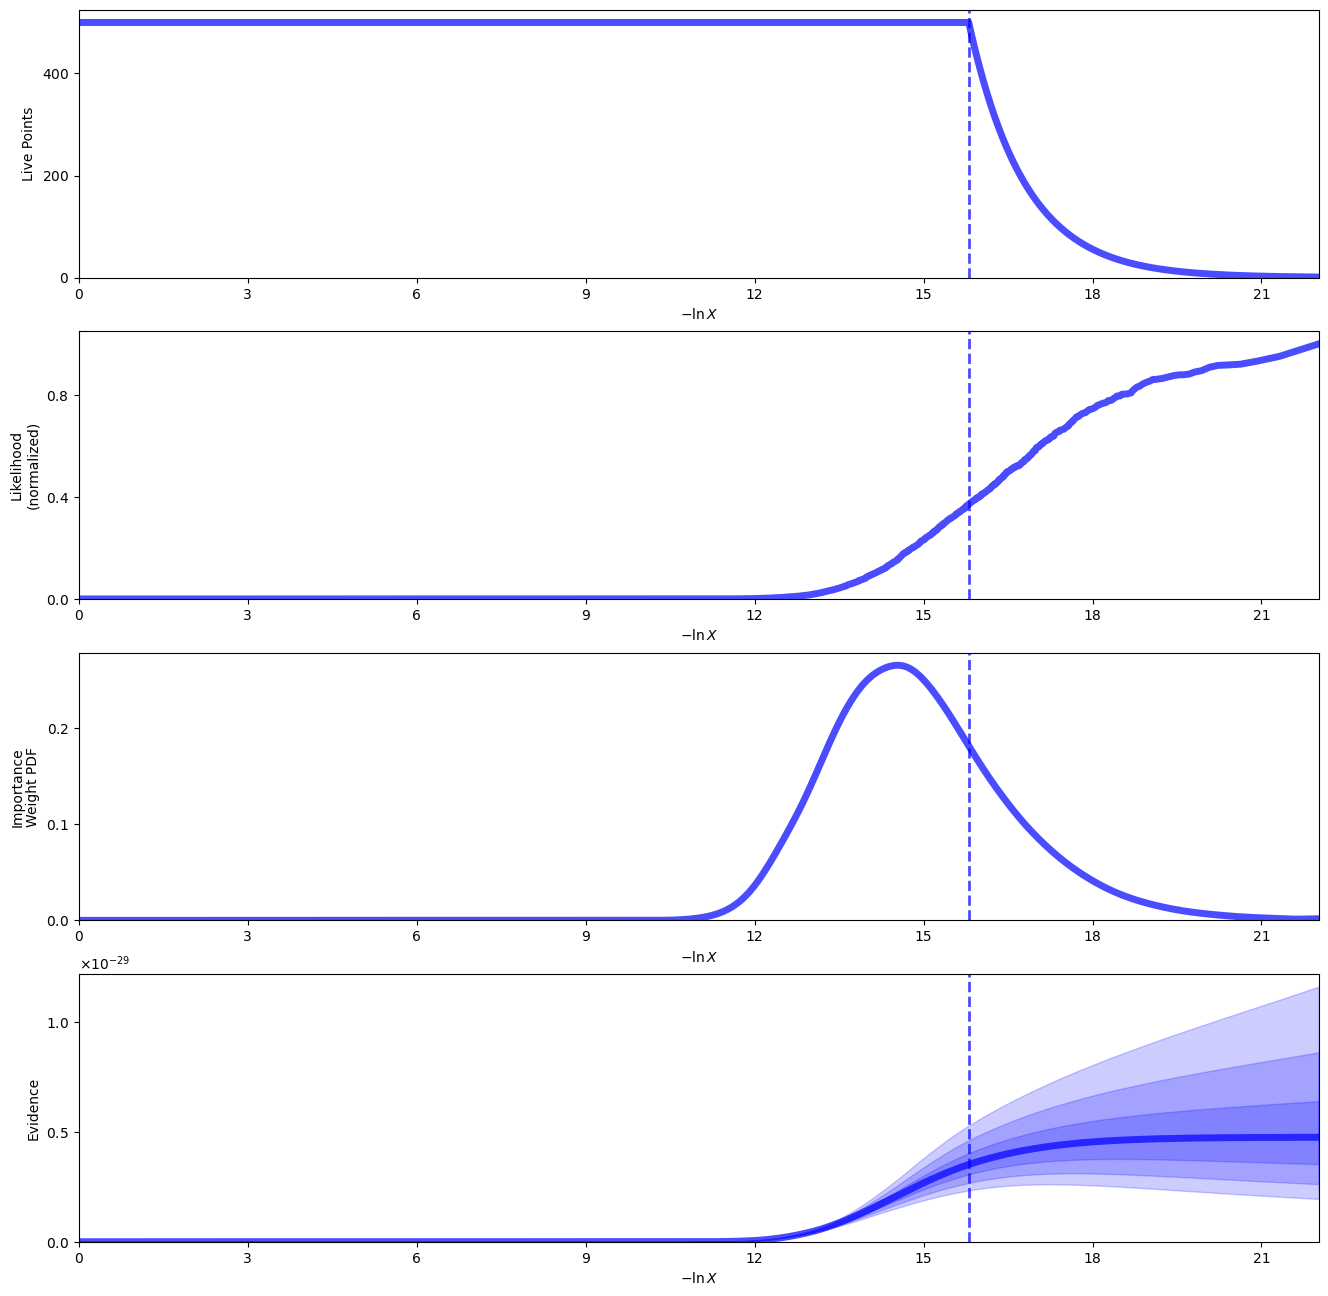

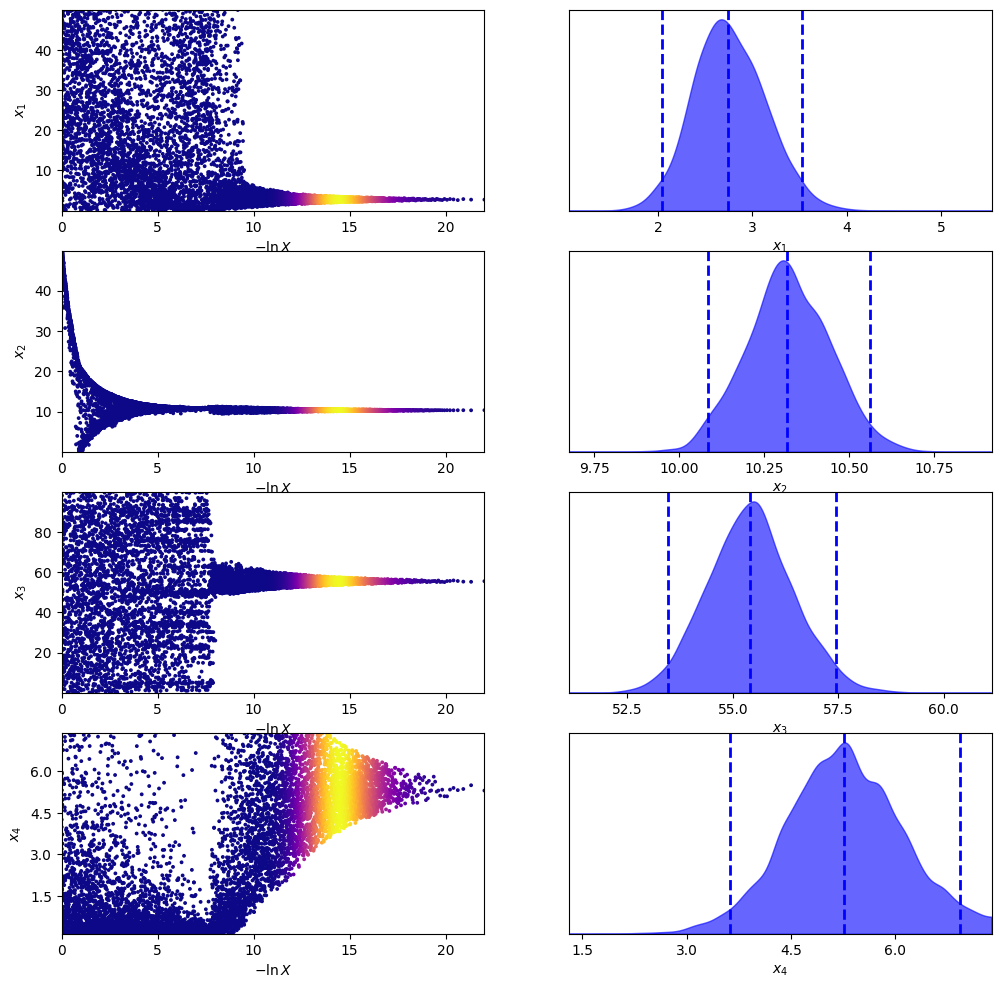

In [24]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(resultsG)
tfig, taxes = dyplot.traceplot(resultsG)
plt.show()

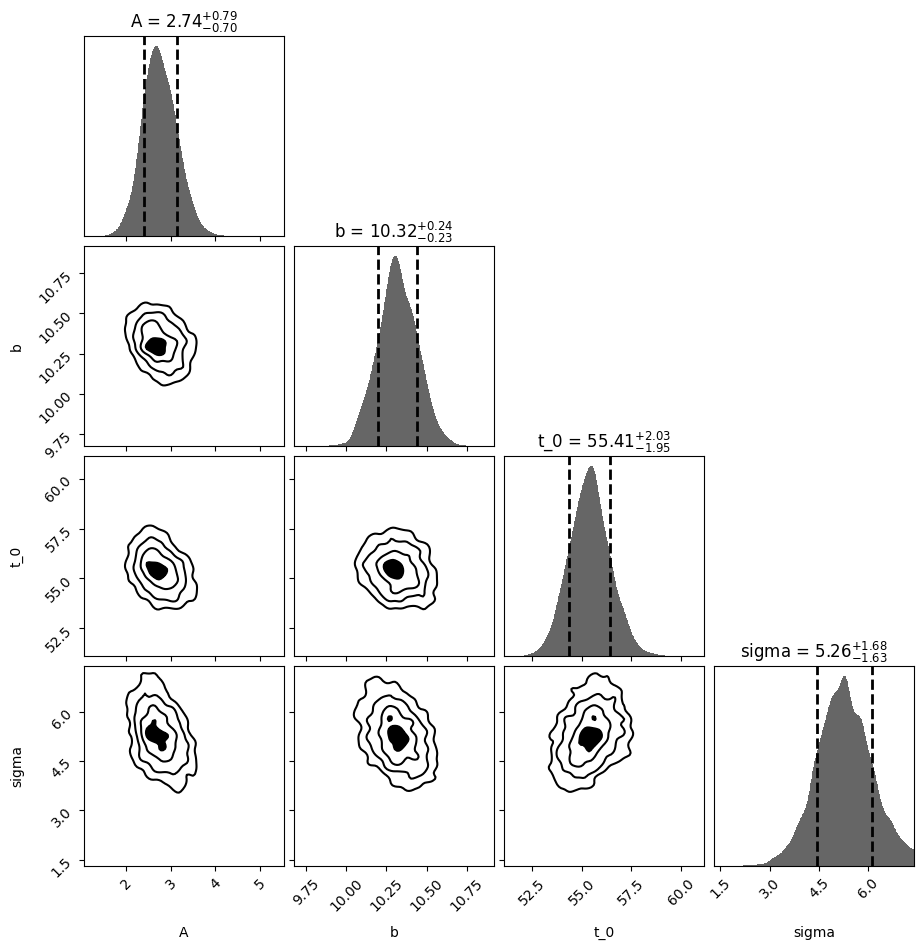

In [25]:
# Plot the cornerplots
labels = ["A", "b", "t_0", "sigma"]
fig, axes = dyplot.cornerplot(resultsG, show_titles=True, quantiles=[0.16, 0.84], labels=labels)
plt.show()

We can now compute the Bayes factor:

In [34]:
B = np.exp(results.logz[-1])/np.exp(resultsG.logz[-1])
print(B)

54.616809403002556


This value tells us that the evidence of the burst model being better at describing the data than the gaussian model is very strong.